# <center>**01_eda_dataset_statistics**</center>

### Table of Contents

1. **Notebook Overview**  
   - Objective of the descriptive analysis  
   - Description of the dataset 
   - Role of these databases in the CNN training and evaluation pipeline  

2. **Environment Setup**  
   - Import of required libraries  
   - Definition of file paths and basic configuration  

3. **Load Databases**  
   - Load the three anonymised datasets from feather files  
   - Basic integrity checks (shape, column names, first rows)  

4. **Variable Inspection**  
   - Data types and basic cleaning  
   - Harmonisation of key variables (e.g. calcification label coding)  

5. **Descriptive Statistics for Quantitative Variables**  
   - Age computation from birth date and radiograph date  
   - Exposure Index (EI)  
   - Summary statistics (mean, SD, median, IQR, range, skewness, kurtosis)  
   - Comparison of age and EI 
   - Age and EI stratified by calcific tendinopathy (No / Yes)  
   - Descriptive tables for each dataset  
   - Visualisation: histograms, boxplots and violin plots by group  

6. **Descriptive Statistics for Categorical Variables**  
   - Frequency tables for sex, laterality, projection, manufacturer and acquisition settings  
   - Distribution by dataset  
   - Distribution stratified by calcification status (No / Yes)  
   - Contingency tables (e.g. sex vs calcification, projection vs calcification)
   - Visualisation: barplots by group  

7. **Temporal Distribution of Radiographs**  
   - Annual frequency tables per dataset  
   - Combined and per-dataset visualisation of radiograph counts by year  

8. **Summary and Conclusions**  
    - Global description of the study population across datasets  
    - Differences between patients with and without calcific tendinopathy  
    - Implications for model development and external validation  


### **1. Notebook Overview**

This notebook performs a descriptive statistical analysis of the anonymised clinical and imaging metadata used throughout the thesis for training and evaluating convolutional neural networks (CNNs) in a binary classification setting (presence vs absence of rotator cuff tendon calcifications). One dataset is analysed, reflecting different time periods, acquisition systems and clinical workflows.

The goal is to characterise the study population and imaging conditions in terms of age, sex, laterality, projection type, exposure index and acquisition hardware, both globally and stratified by calcification status. Quantitative variables are summarised using standard descriptive statistics and visualised with histograms, boxplots and violin plots, while categorical variables are described through frequency tables and barplots.

These descriptive results provide context for the subsequent CNN experiments, helping to understand potential sources of distribution shift between datasets (e.g. demographic or technical differences) and to interpret model performance in light of the underlying data characteristics. No patient-identifying information is used or displayed in this notebook.

### **2. Environment Setup**

In [1]:
# Environment setup: core libraries for descriptive statistics and plotting

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

# Silence non-critical warnings (e.g. deprecations) to keep the notebook output clean
warnings.filterwarnings("ignore", category=FutureWarning)

# Basic plotting style
sns.set_style("whitegrid")


### **3. Load Databases**

In [11]:
# Load retrospective training and prospective testing CSV files (stratified subsets of the full dataset)

train_df = pd.read_csv("train_subset.csv")
test_df = pd.read_csv("test_subset.csv")

# Print subset shapes
print(f"Train subset shape: {train_df.shape}")
print(f"Test subset shape : {test_df.shape}")

# Display column names
display(train_df.head(0))
display(test_df.head(0))


Train subset shape: (4268, 20)
Test subset shape : (480, 20)


,Unnamed: 0,NHC,epi_cod,rx_cod,proje,manufacturer,manufacturer_model,station_name,voilutfunction,birthdate,sex,ei,date_rx,label_CalTend,label_CalTend_sub,label_CalTend_supr,label_CalTend_infr,size,complentary_expl,lat_rx


,Unnamed: 0,NHC,epi_cod,rx_cod,proje,manufacturer,manufacturer_model,station_name,voilutfunction,birthdate,sex,ei,date_rx,label_CalTend,label_CalTend_sub,label_CalTend_supr,label_CalTend_infr,size,complentary_expl,lat_rx


In [2]:
# Paths to the dataset
path_base = 'df_all_1ª_base_datos_final.feather'

# Load the dataset
df_base = pd.read_feather(path_base)

# Print shapes to confirm successful loading 
print(f"Base 1 – Shape: {df_base.shape}")

# Preview the first rows of each dataset
print("\nFirst dataset (Base 1):")
display(df_base.head(0))


Base 1 – Shape: (4748, 20)

First dataset (Base 1):


,Unnamed: 0,NHC,epi_cod,rx_cod,proje,manufacturer,manufacturer_model,station_name,voilutfunction,birthdate,sex,ei,date_rx,label_CalTend,label_CalTend_sub,label_CalTend_supr,label_CalTend_infr,size,complentary_expl,lat_rx


### **4. Variable Inspection**

In [3]:
# Check dtypes for the dataset

print("\nData types – Base 1")
print(df_base.dtypes)



Data types – Base 1
Unnamed: 0              int64
NHC                    object
epi_cod                object
rx_cod                 object
proje                  object
manufacturer           object
manufacturer_model     object
station_name           object
voilutfunction         object
birthdate              object
sex                    object
ei                    float64
date_rx                object
label_CalTend           int64
label_CalTend_sub      object
label_CalTend_supr     object
label_CalTend_infr     object
size                  float64
complentary_expl       object
lat_rx                 object
dtype: object


### **5. Descriptive Statistics for Quantitative Variables**

In [4]:
def normalize_yes_no(series):
    mapping = {
        0: 'No', 1: 'Yes',
        '0': 'No', '1': 'Yes',
        'No': 'No', 'NO': 'No', 'no': 'No', 'N': 'No',
        'Sí': 'Yes', 'Si': 'Yes', 'SI': 'Yes', 'sí': 'Yes',
        'Yes': 'Yes', 'YES': 'Yes', 'yes': 'Yes',
        True: 'Yes', False: 'No'
    }
    s = series.replace(mapping)
    return pd.Categorical(s, categories=['No', 'Yes'], ordered=True)

# Apply directly
for df in [df_base]:
    df['label_CalTend'] = normalize_yes_no(df['label_CalTend'])

# Verification
print("Base 1:", df_base['label_CalTend'].unique())


Base 1: ['No', 'Yes']
Categories (2, object): ['No' < 'Yes']


In [5]:
def sdescriptive(df, var, round_=0, save_path=False):
    """
    Compute a set of descriptive statistics for a numeric variable in a DataFrame.

    This function calculates standard descriptive measures such as mean, standard deviation,
    median, interquartile range (IQR), range, minimum, maximum, skewness, and kurtosis.
    By default, all values are rounded to the specified number of decimals (round_). If
    a file path is provided (save_path), the resulting statistics are also saved in CSV
    and Excel formats.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the dataset.
    var : str
        Name of the column (variable) for which descriptive statistics will be computed.
    round_ : int, optional
        Number of decimal places to which the results should be rounded. Defaults to 0.
    save_path : bool or str, optional
        If False (default), the function does not save any file. If a string is provided,
        it is used as the base path (without extension) for saving the results to CSV and
        Excel files (e.g. 'path/filename').

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the descriptive statistics for the specified variable,
        with the following metrics as rows:
        - Mean
        - Standard deviation
        - Median
        - Interquartile range (IQR)
        - Range
        - Minimum
        - Maximum
        - Skewness
        - Kurtosis (Fisher definition: normal distribution == 0)
    """

    # Basic descriptive statistics: count, mean, std, min, quartiles, max
    stats_var = df[var].describe().round(round_)

    # Interquartile range and range
    stats_var['iqr'] = stats_var['75%'] - stats_var['25%']
    stats_var['range'] = stats_var['max'] - stats_var['min']

    # Skewness and kurtosis (Fisher definition: normal == 0)
    stats_var['skew'] = df[var].skew().round(round_)
    stats_var['kurt'] = df[var].kurt().round(round_)

    # Select and reorder statistics of interest
    stats_var = stats_var.loc[
        ['mean', 'std', '50%', 'iqr', 'range', 'min', 'max', 'skew', 'kurt']
    ].to_frame('Value')

    # Rename index to English labels and rename the column to the variable name
    stats_var.index = [
        'Mean',
        'Std. deviation',
        'Median',
        'IQR',
        'Range',
        'Min',
        'Max',
        'Skewness',
        'Kurtosis'
    ]
    stats_var = stats_var.rename(columns={'Value': var})

    # Optionally save to CSV and Excel
    if save_path is not False:
        stats_var.to_csv(f'{save_path}.csv')
        stats_var.to_excel(f'{save_path}.xlsx')

    return stats_var


In [6]:
# List of DataFrames and corresponding names
bases = [df_base]
names = ['Base 1']

# Lists to store results
stats_age_list = []
stats_ei_list = []

for df in bases:
    # === Convert date columns to datetime (errors coerced to NaT) ===
    df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
    df['date_rx'] = pd.to_datetime(df['date_rx'], format='mixed', dayfirst=True, errors='coerce')

    # === Compute age in years at the time of the radiograph ===
    df['age_years'] = (df['date_rx'] - df['birthdate']).dt.days / 365.25

    # Age: keep 1 decimal, since age in years is a continuous clinical variable
    # and a single decimal provides a reasonable level of detail.
    stats_age = sdescriptive(df=df, var='age_years', round_=1)

    # EI: report as integer, as it is typically handled as a technical index
    # and additional decimals are not clinically meaningful.
    stats_ei = sdescriptive(df=df, var='ei', round_=0)

    stats_age_list.append(stats_age)
    stats_ei_list.append(stats_ei)

# Combine results into a single table for age and another for EI
df_stats_age = pd.concat(stats_age_list, axis=1)
df_stats_age.columns = names

df_stats_ei = pd.concat(stats_ei_list, axis=1)
df_stats_ei.columns = names


def _format_descriptive_table(df):
    """
    Format descriptive statistics table so that values that are
    exactly integer are displayed without a trailing '.0'.
    Non-integer values keep their decimal part.
    """
    def fmt(x):
        try:
            x_float = float(x)
        except (TypeError, ValueError):
            return x
        return int(x_float) if x_float.is_integer() else x_float

    out = df.copy()
    for col in out.columns:
        out[col] = out[col].apply(fmt)
    return out


df_stats_age_display = _format_descriptive_table(df_stats_age)
df_stats_ei_display = _format_descriptive_table(df_stats_ei)

print("Descriptive statistics – Age (years):")
display(df_stats_age_display)

print("\nDescriptive statistics – Exposure Index (EI):")
display(df_stats_ei_display)


Descriptive statistics – Age (years):


,Base 1
Mean,51.6
Std. deviation,13.2
Median,50.8
IQR,16.9
Range,77.5
Min,10.9
Max,88.4
Skewness,0.0
Kurtosis,0.1



Descriptive statistics – Exposure Index (EI):


,Base 1
Mean,117
Std. deviation,91
Median,95
IQR,132
Range,428
Min,3
Max,431
Skewness,1
Kurtosis,0


In [8]:
# Descriptive statistics for age and EI by tendon calcification status (No / Yes)

stats_by_tc_list = []
bases = [df_base]
names = ['Base 1']

for df in bases:
    df_valid = df.copy()

    # Ensure age_years exists (safeguard in case this cell is run independently)
    if 'age_years' not in df_valid.columns:
        df_valid['birthdate'] = pd.to_datetime(df_valid['birthdate'], errors='coerce')
        df_valid['date_rx'] = pd.to_datetime(df_valid['date_rx'], format='mixed', dayfirst=True, errors='coerce')
        df_valid['age_years'] = (df_valid['date_rx'] - df_valid['birthdate']).dt.days / 365.25

    # Drop rows with missing values in age, EI or label
    df_valid = df_valid.dropna(subset=['age_years', 'ei', 'label_CalTend'])

    # Group by presence of calcification (label_CalTend: 'No' / 'Yes')
    # Age: keep 1 decimal (continuous clinical variable)
    stats_age_tc = df_valid.groupby('label_CalTend').apply(
        lambda g: sdescriptive(g, var='age_years', round_=1),
        include_groups=False
    )

    # EI: integer-level reporting (technical index)
    stats_ei_tc = df_valid.groupby('label_CalTend').apply(
        lambda g: sdescriptive(g, var='ei', round_=0),
        include_groups=False
    )

    # Combine age and EI statistics side by side
    df_stats_edad_ei_tc = pd.concat(
        [stats_age_tc, stats_ei_tc],
        axis=1,
        keys=['Age (years)', 'Exposure Index (EI)']
    )

    # Apply the same formatting as in the global tables (remove .0 when exact integer)
    df_stats_edad_ei_tc = _format_descriptive_table(df_stats_edad_ei_tc)

    stats_by_tc_list.append(df_stats_edad_ei_tc)

# Display results for each dataset
for name, df_stats in zip(names, stats_by_tc_list):
    print(f"\nDescriptive statistics by tendon calcification status – {name}")
    display(df_stats)



Descriptive statistics by tendon calcification status – Base 1


Age (years) Exposure Index (EI)
                               age_years                  ei
label_CalTend                                               
No            Mean                  51.7                 121
              Std. deviation        15.6                  91
              Median                51.8                  99
              IQR                   22.1                 129
              Range                 77.5                 396
              Min                   10.9                   4
              Max                   88.4                 400
              Skewness              -0.2                   1
              Kurtosis              -0.4                   0
Yes           Mean                  51.5                 114
              Std. deviation        10.2                  91
              Median                50.1                  91
              IQR                   13.1                 134
              Range                 57.4                 428
              Min                   27.3                   3
              Max                   84.7                 431
              Skewness               0.7                   1
              Kurtosis               0.3                   0

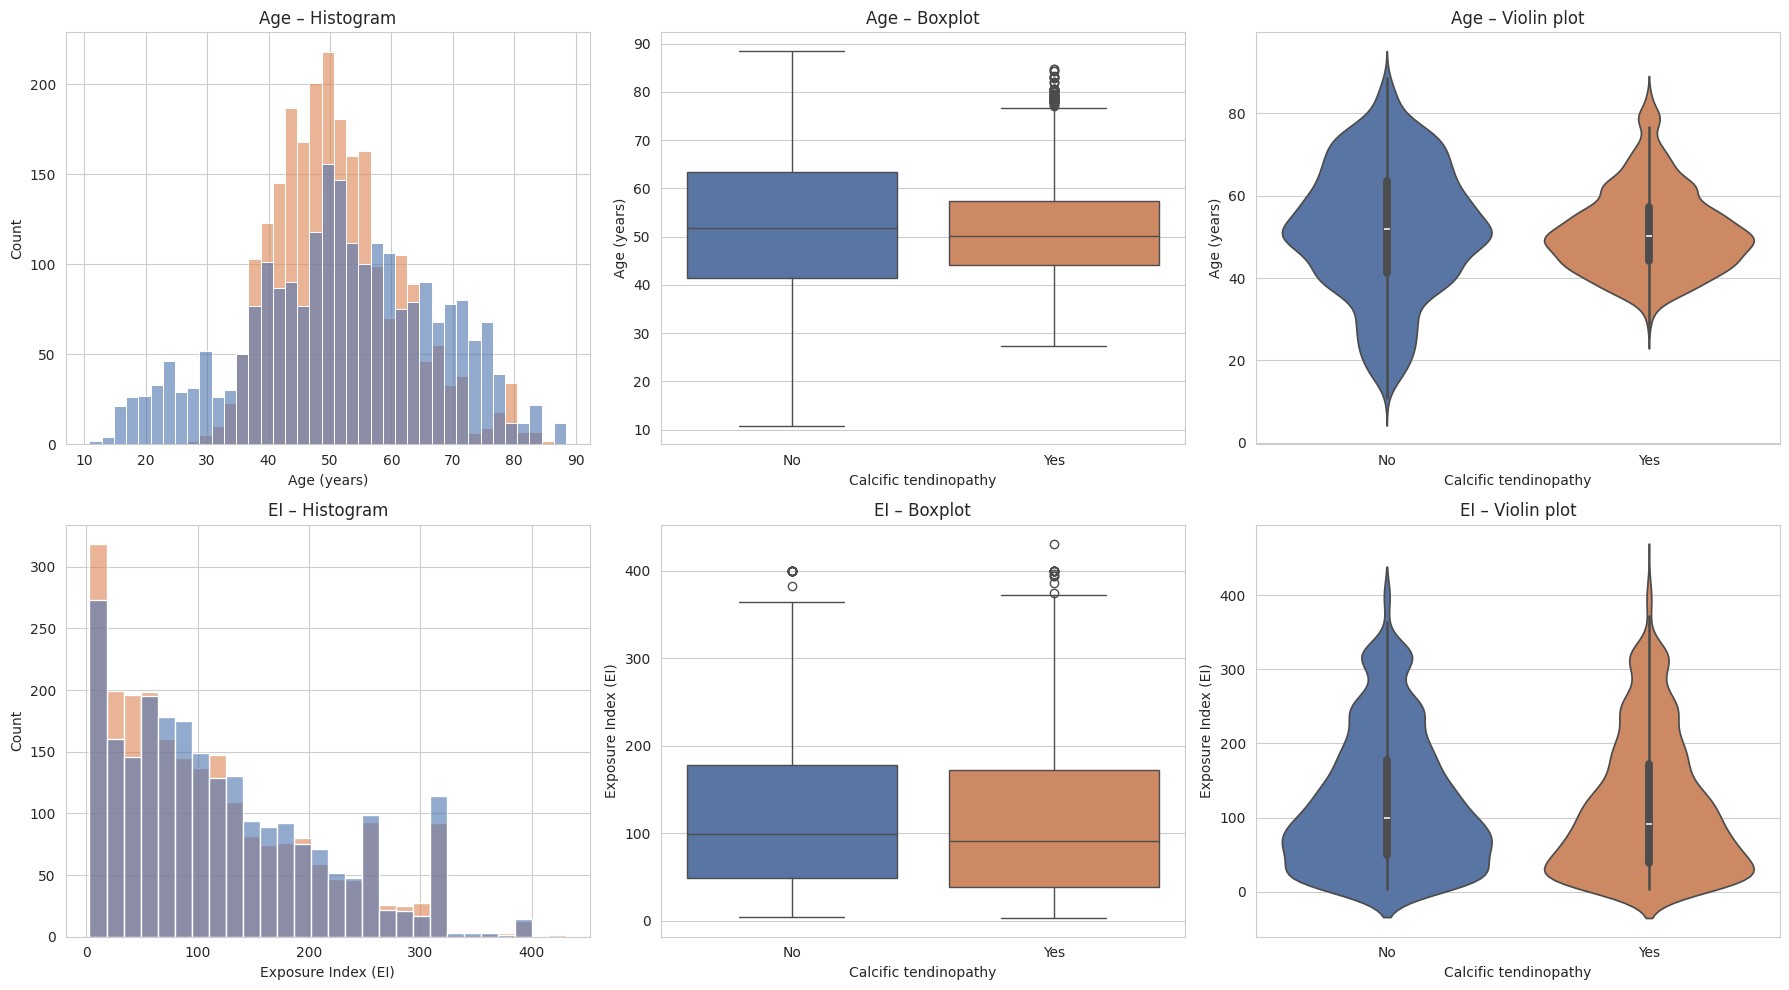

In [9]:
# Ensure consistent categorical order for calcification label
df_base['label_CalTend'] = pd.Categorical(
    df_base['label_CalTend'],
    categories=['No', 'Yes'],
    ordered=True
)

# Nice color palette for Base 1
palette = ['#4C72B0', '#DD8452']  # blue / orange
palette_dict = {'No': palette[0], 'Yes': palette[1]}

sns.set_style('whitegrid')

# Prepare data
df_plot = df_base.copy()
df_plot['birthdate'] = pd.to_datetime(df_plot['birthdate'], errors='coerce')
df_plot['date_rx'] = pd.to_datetime(df_plot['date_rx'], format='mixed', dayfirst=True, errors='coerce')
df_plot['age_years'] = (df_plot['date_rx'] - df_plot['birthdate']).dt.days / 365.25
df_plot = df_plot.dropna(subset=['age_years', 'ei', 'label_CalTend'])

# 2 rows x 3 columns: Age (top), EI (bottom)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# ---------- AGE (top row) ----------
sns.histplot(
    data=df_plot,
    x='age_years',
    hue='label_CalTend',
    hue_order=['No', 'Yes'],
    palette=palette_dict,
    alpha=0.6,
    multiple='layer',
    kde=False,
    ax=axes[0, 0]
)
if axes[0, 0].legend_ is not None:
    axes[0, 0].legend_.remove()

axes[0, 0].set_title('Age – Histogram')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Count')


sns.boxplot(
    data=df_plot,
    x='label_CalTend',
    y='age_years',
    order=['No', 'Yes'],
    hue='label_CalTend',
    hue_order=['No', 'Yes'],
    palette=palette_dict,
    dodge=False,
    ax=axes[0, 1]
)
if axes[0, 1].legend_ is not None:
    axes[0, 1].legend_.remove()
axes[0, 1].set_title('Age – Boxplot')
axes[0, 1].set_xlabel('Calcific tendinopathy')
axes[0, 1].set_ylabel('Age (years)')

sns.violinplot(
    data=df_plot,
    x='label_CalTend',
    y='age_years',
    order=['No', 'Yes'],
    hue='label_CalTend',
    hue_order=['No', 'Yes'],
    palette=palette_dict,
    dodge=False,
    inner='box',
    ax=axes[0, 2]
)
if axes[0, 2].legend_ is not None:
    axes[0, 2].legend_.remove()
axes[0, 2].set_title('Age – Violin plot')
axes[0, 2].set_xlabel('Calcific tendinopathy')
axes[0, 2].set_ylabel('Age (years)')

# ---------- EI (bottom row) ----------
sns.histplot(
    data=df_plot,
    x='ei',
    hue='label_CalTend',
    hue_order=['No', 'Yes'],
    palette=palette_dict,
    alpha=0.6,
    multiple='layer',
    kde=False,
    ax=axes[1, 0]
)
if axes[1, 0].legend_ is not None:
    axes[1, 0].legend_.remove()

axes[1, 0].set_title('EI – Histogram')
axes[1, 0].set_xlabel('Exposure Index (EI)')
axes[1, 0].set_ylabel('Count')


sns.boxplot(
    data=df_plot,
    x='label_CalTend',
    y='ei',
    order=['No', 'Yes'],
    hue='label_CalTend',
    hue_order=['No', 'Yes'],
    palette=palette_dict,
    dodge=False,
    ax=axes[1, 1]
)
if axes[1, 1].legend_ is not None:
    axes[1, 1].legend_.remove()
axes[1, 1].set_title('EI – Boxplot')
axes[1, 1].set_xlabel('Calcific tendinopathy')
axes[1, 1].set_ylabel('Exposure Index (EI)')

sns.violinplot(
    data=df_plot,
    x='label_CalTend',
    y='ei',
    order=['No', 'Yes'],
    hue='label_CalTend',
    hue_order=['No', 'Yes'],
    palette=palette_dict,
    dodge=False,
    inner='box',
    ax=axes[1, 2]
)
if axes[1, 2].legend_ is not None:
    axes[1, 2].legend_.remove()
axes[1, 2].set_title('EI – Violin plot')
axes[1, 2].set_xlabel('Calcific tendinopathy')
axes[1, 2].set_ylabel('Exposure Index (EI)')

plt.tight_layout()
plt.show()


### **6. Descriptive Statistics for Quantitative Variables**

In [10]:
def freqtab(df, column, decimals=1, title="", print_=False):
    """
    Create a frequency table (count and percentage) for a categorical variable.

    The function returns a table with the absolute count and the percentage
    of each category in the specified column. Missing values are labeled as 'NA'.
    A final 'TOTAL' row is added with the overall count and 100% in the percentage column.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data.
    column : str
        Column name for which the frequency table is computed.
    decimals : int, optional
        Number of decimal places for the percentages. Default is 1.
    title : str, optional
        Text printed before showing the table. Default is an empty string.
    print_ : bool, optional
        If True, the resulting table is displayed. Default is False.

    Returns
    -------
    pandas.DataFrame
        Frequency table with:
        - 'count (n)': absolute frequencies
        - 'percentage (%)': percentages over the total (including NA)
        plus a final 'TOTAL' row.
    """
    df2 = df.copy()

    # Ensure the column exists
    if column not in df2.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame.")

    # Work with a single Series, treating missing values as 'NA'
    series = df2[column]

    # If categorical, add 'NA' to categories to ensure it is represented
    if isinstance(series.dtype, pd.CategoricalDtype):
        series = series.cat.add_categories('NA').fillna('NA')
    else:
        series = series.fillna('NA')

    # Frequency counts
    counts = series.value_counts(dropna=False)
    total = counts.sum()

    # Build table
    table = pd.DataFrame({
        'count (n)': counts,
        'percentage (%)': (counts / total * 100).round(decimals)
    })

    # Add TOTAL row with exact 100% in the percentage column
    total_row = pd.DataFrame(
        {'count (n)': [total],
         'percentage (%)': [100.0]},
        index=['TOTAL']
    )
    table = pd.concat([table, total_row], axis=0)

    # Set index name to the variable name
    table = table.rename_axis(column)

    if title:
        print(title)
    if print_:
        display(table)

    return table


In [11]:
# List of categorical variables to analyse
categorical_vars = [
    'sex',
    'label_CalTend',
    'lat_rx',
    'proje',
    'manufacturer',
    'manufacturer_model',
    'station_name',
    'voilutfunction',
    'complentary_expl'
]

# Single base
df = df_base
name = 'Base 1'

# Frequency tables for overall sample and by calcification status
print(f"\n{name} — Overall sample")
print("-" * 60)
for col in categorical_vars:
    freqtab(
        df=df,
        column=col,
        decimals=1,
        title=f'{col} (overall sample)',
        print_=True
    )

print(f"\n{name} — Patients with calcific tendinopathy (TC = Yes)")
print("-" * 60)
df_yes = df[df['label_CalTend'] == 'Yes']
for col in categorical_vars:
    freqtab(
        df=df_yes,
        column=col,
        decimals=1,
        title=f'{col} (TC = Yes)',
        print_=True
    )

print(f"\n{name} — Patients without calcific tendinopathy (TC = No)")
print("-" * 60)
df_no = df[df['label_CalTend'] == 'No']
for col in categorical_vars:
    freqtab(
        df=df_no,
        column=col,
        decimals=1,
        title=f'{col} (TC = No)',
        print_=True
    )



Base 1 — Overall sample
------------------------------------------------------------
sex (overall sample)


,count (n),percentage (%)
sex,,
F,2866,60.4
M,1882,39.6
TOTAL,4748,100.0


label_CalTend (overall sample)


,count (n),percentage (%)
label_CalTend,,
No,2374,50.0
Yes,2374,50.0
NA,0,0.0
TOTAL,4748,100.0


lat_rx (overall sample)


,count (n),percentage (%)
lat_rx,,
D,2723,57.4
I,2025,42.6
TOTAL,4748,100.0


proje (overall sample)


,count (n),percentage (%)
proje,,
RI,2383,50.2
RE,2365,49.8
TOTAL,4748,100.0


manufacturer (overall sample)


,count (n),percentage (%)
manufacturer,,
Canon Inc.,4748,100.0
TOTAL,4748,100.0


manufacturer_model (overall sample)


,count (n),percentage (%)
manufacturer_model,,
CXDI Control Software NE,4748,100.0
TOTAL,4748,100.0


station_name (overall sample)


,count (n),percentage (%)
station_name,,
CZC1198HNN,2202,46.4
RADIOLOGIA-HP,1812,38.2
MININT-VSAMOTD,734,15.5
TOTAL,4748,100.0


voilutfunction (overall sample)


,count (n),percentage (%)
voilutfunction,,
LINEAR,4748,100.0
TOTAL,4748,100.0


complentary_expl (overall sample)


,count (n),percentage (%)
complentary_expl,,
Sí,3942,83.0
No,806,17.0
TOTAL,4748,100.0



Base 1 — Patients with calcific tendinopathy (TC = Yes)
------------------------------------------------------------
sex (TC = Yes)


,count (n),percentage (%)
sex,,
F,1573,66.3
M,801,33.7
TOTAL,2374,100.0


label_CalTend (TC = Yes)


,count (n),percentage (%)
label_CalTend,,
Yes,2374,100.0
No,0,0.0
NA,0,0.0
TOTAL,2374,100.0


lat_rx (TC = Yes)


,count (n),percentage (%)
lat_rx,,
D,1365,57.5
I,1009,42.5
TOTAL,2374,100.0


proje (TC = Yes)


,count (n),percentage (%)
proje,,
RI,1196,50.4
RE,1178,49.6
TOTAL,2374,100.0


manufacturer (TC = Yes)


,count (n),percentage (%)
manufacturer,,
Canon Inc.,2374,100.0
TOTAL,2374,100.0


manufacturer_model (TC = Yes)


,count (n),percentage (%)
manufacturer_model,,
CXDI Control Software NE,2374,100.0
TOTAL,2374,100.0


station_name (TC = Yes)


,count (n),percentage (%)
station_name,,
CZC1198HNN,1101,46.4
RADIOLOGIA-HP,906,38.2
MININT-VSAMOTD,367,15.5
TOTAL,2374,100.0


voilutfunction (TC = Yes)


,count (n),percentage (%)
voilutfunction,,
LINEAR,2374,100.0
TOTAL,2374,100.0


complentary_expl (TC = Yes)


,count (n),percentage (%)
complentary_expl,,
Sí,2214,93.3
No,160,6.7
TOTAL,2374,100.0



Base 1 — Patients without calcific tendinopathy (TC = No)
------------------------------------------------------------
sex (TC = No)


,count (n),percentage (%)
sex,,
F,1293,54.5
M,1081,45.5
TOTAL,2374,100.0


label_CalTend (TC = No)


,count (n),percentage (%)
label_CalTend,,
No,2374,100.0
Yes,0,0.0
NA,0,0.0
TOTAL,2374,100.0


lat_rx (TC = No)


,count (n),percentage (%)
lat_rx,,
D,1358,57.2
I,1016,42.8
TOTAL,2374,100.0


proje (TC = No)


,count (n),percentage (%)
proje,,
RE,1187,50.0
RI,1187,50.0
TOTAL,2374,100.0


manufacturer (TC = No)


,count (n),percentage (%)
manufacturer,,
Canon Inc.,2374,100.0
TOTAL,2374,100.0


manufacturer_model (TC = No)


,count (n),percentage (%)
manufacturer_model,,
CXDI Control Software NE,2374,100.0
TOTAL,2374,100.0


station_name (TC = No)


,count (n),percentage (%)
station_name,,
CZC1198HNN,1101,46.4
RADIOLOGIA-HP,906,38.2
MININT-VSAMOTD,367,15.5
TOTAL,2374,100.0


voilutfunction (TC = No)


,count (n),percentage (%)
voilutfunction,,
LINEAR,2374,100.0
TOTAL,2374,100.0


complentary_expl (TC = No)


,count (n),percentage (%)
complentary_expl,,
Sí,1728,72.8
No,646,27.2
TOTAL,2374,100.0


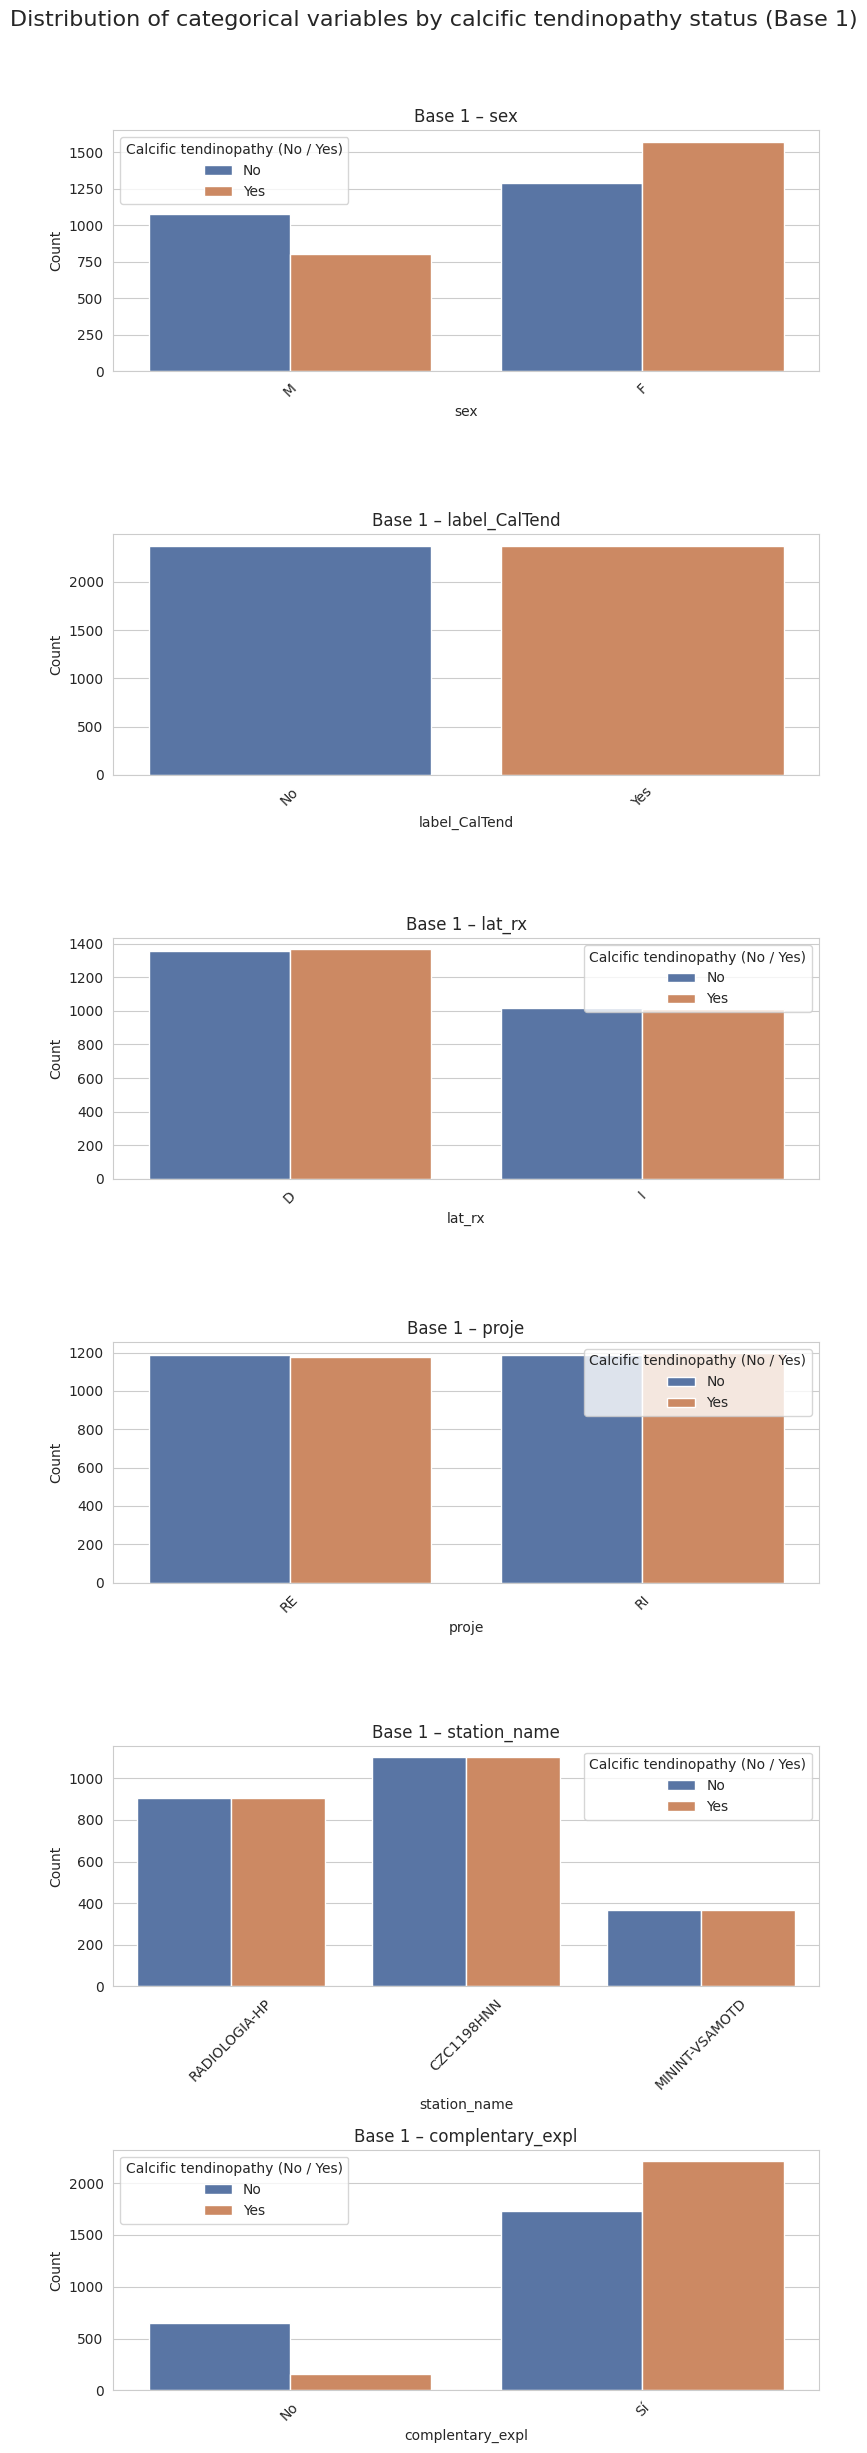

In [12]:
# Ensure consistent order for calcification label and laterality (single base)

df_base['label_CalTend'] = pd.Categorical(
    df_base['label_CalTend'],
    categories=['No', 'Yes'],
    ordered=True
)

df_base['lat_rx'] = pd.Categorical(
    df_base['lat_rx'],
    categories=['D', 'I'],
    ordered=True
)

# Color palette for Base 1
palette = ['#4C72B0', '#DD8452']  # No / Yes

# Categorical variables to analyse
categorical_vars = [
    'sex',
    'label_CalTend',
    'lat_rx',
    'proje',
    'manufacturer',
    'manufacturer_model',
    'station_name',
    'voilutfunction',
    'complentary_expl'
]

# Keep only variables with > 1 non-null category
valid_categories = [
    var for var in categorical_vars
    if df_base[var].nunique(dropna=True) > 1
]

nrows = len(valid_categories)
ncols = 1  # single dataset

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(8, 4 * nrows),
    sharey=False
)

fig.suptitle(
    "Distribution of categorical variables by calcific tendinopathy status (Base 1)",
    fontsize=16,
    y=1.02
)

if nrows == 1:
    axes = [axes]

sns.set_style('whitegrid')

for row_idx, var in enumerate(valid_categories):
    ax = axes[row_idx]

    try:
        sns.countplot(
            data=df_base,
            x=var,
            hue='label_CalTend',
            hue_order=['No', 'Yes'],
            palette=palette,
            ax=ax
        )
        ax.set_title(f'Base 1 – {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

        if ax.legend_ is not None:
            ax.legend(
                title='Calcific tendinopathy (No / Yes)',
                loc='best'
            )

    except Exception as e:
        ax.set_visible(False)
        print(f'Error plotting {var}: {e}')

plt.tight_layout()
plt.show()


### **7. Temporal Distribution of Radiographs**


Base 1 – Annual frequency table
--------------------------------------------------
col_0  Count  Percentage (%)
2014       2            0.04
2017       2            0.04
2018       5            0.11
2019       4            0.08
2020      20            0.42
2021     561           11.83
2022     833           17.57
2023    1612           33.99
2024    1313           27.69
2025     390            8.22
TOTAL   4742          100.00


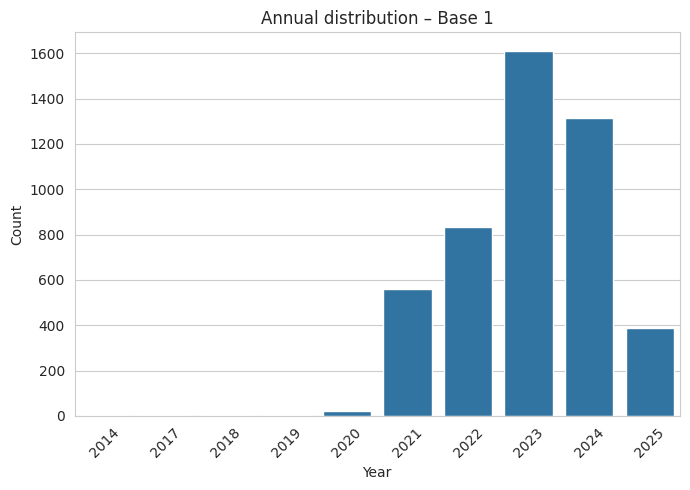

In [13]:
# Palette and dataset name (single base)
palette = '#1f77b4'   
name = 'Base 1'
df = df_base

# Output folder
output_folder = 'Figures/Descriptive_statistics'
os.makedirs(output_folder, exist_ok=True)

# Work on a copy to avoid modifying the original DataFrame
df_tmp = df.copy()

# Parse dates and drop invalid ones
df_tmp['date_rx'] = pd.to_datetime(df_tmp['date_rx'], errors='coerce')
df_tmp = df_tmp.dropna(subset=['date_rx']).copy()

# Extract year as string
df_tmp['date_rx_year'] = df_tmp['date_rx'].dt.year.astype(int).astype(str)

# Frequency table by year
table = pd.crosstab(index=df_tmp['date_rx_year'], columns='Count')
table['Percentage (%)'] = (table['Count'] / table['Count'].sum() * 100).round(2)

# Add TOTAL row with exact 100%
total_row = pd.DataFrame(
    data=[[table['Count'].sum(), 100.00]],
    columns=table.columns,
    index=['TOTAL']
)
table = pd.concat([table, total_row])

# Show table in the notebook
print(f"\n{name} – Annual frequency table")
print("-" * 50)
print(table)

# Save table
table.to_csv(f"{output_folder}/{name}_annual_frequency.csv", index=True)
table.to_excel(f"{output_folder}/{name}_annual_frequency.xlsx", index=True)

# ---------- Plot ----------
sns.set_style('whitegrid')

# Ensure chronological order of years on the x-axis
year_order = sorted(df_tmp['date_rx_year'].unique(), key=lambda x: int(x))

fig, ax = plt.subplots(figsize=(7, 5))

sns.countplot(
    data=df_tmp,
    x='date_rx_year',
    order=year_order,
    color=palette,
    ax=ax
)

ax.set_title(f'Annual distribution – {name}')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"{output_folder}/date_rx_annual_countplot_{name}.png", dpi=300)
plt.show()


### **8. Summary and Conclusions**

This notebook provides a descriptive overview of the anonymised clinical and imaging dataset used in the experiment. Across all databases, the population spans a wide adult age range with comparable central tendencies, and a balanced representation of sexes and radiographic laterality. The EI and acquisition-related variables show that images were acquired under reasonably consistent technical conditions, although some differences between acquisition systems are evident.

When stratifying by calcific tendinopathy status, patients with and without tendon calcifications showed broadly similar age distributions, and no extreme deviations were observed in EI or basic acquisition parameters between groups. The distributions of projection type, manufacturer and station name reflect the clinical workflows and equipment installed in each centre rather than systematic differences between calcified and non-calcified cases. Importantly, all descriptive summaries were computed on fully anonymised data, without exposing direct identifiers or potentially re-identifying combinations.

The temporal analysis of radiograph counts by year highlights how case accrual varies across the dataset and time, which is relevant for understanding potential temporal shifts in clinical practice or acquisition protocols. Together, these descriptive findings provide essential context for the experiment: they clarify the demographic and technical landscape in which the models were trained and evaluated, help to interpret performance differences between internal and external tests, and support a cautious assessment of how far the learned models can be expected to generalise beyond the specific populations and acquisition conditions represented here.